In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [138]:
def fibre_propagation(U0, wvl, x, z, refractive_index):
    nx = U0.shape[0]
    k = 2 * torch.pi / wvl

    dx = torch.abs(x[1] - x[0])
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)

    U_out = torch.zeros(nx, z.shape[0], device=U0.device) + 0j
    U_out[:, 0] = U0 

    absorbing_window = torch.exp(-(x / (10e-6))**20)
    dz = torch.abs(z[1] - z[0])
    
    H = torch.exp(1j * k * dz * torch.sqrt(1 + 0j - (wvl * fx) ** 2))
    for i in range(1, z.shape[0]):
        U_in = U_out[:, i - 1]
        phase_shift = torch.exp(1j * k * dz * refractive_index[:, i - 1]) * absorbing_window
        U1 = torch.fft.fftshift(torch.fft.ifft(torch.fft.fft(torch.fft.ifftshift(U_out[:, i - 1] * phase_shift)) * H))
        U_out[:, i] = U1
        

    return U_out

# GX_11

You are given a fibre with the parameters written below. 
Try to launch fundamental modes into the fibre. For simplicity, assume that the fundamental modes can be expressed as 

$$f_n(x) = \begin{cases}
\cos\left(\frac{n\pi x}{2r_{\text{core}}}\right) & \text{if } -r_{\text{core}} \leq x \leq r_{\text{core}} \\
0 & \text{otherwise}
\end{cases}$$
for $n \in {1,3,5, ...}$ and
$$f_n(x) = \begin{cases}
\sin\left(\frac{n\pi x}{2r_{\text{core}}}\right) & \text{if } -r_{\text{core}} \leq x \leq r_{\text{core}} \\
0 & \text{otherwise}
\end{cases}$$
for $n \in {2,4,6, ...}$


The $V$ number of the waveguide and the number of modes can be expressed as:
$$V = \frac{2\pi}{\lambda} \cdot (2r_{\text{core}}) \cdot \sqrt{n_{\text{core}}^2 - n_{\text{cladding}}^2}$$
$$\text{number\_modes} = \frac{V}{\pi} + 0.5$$


Tasks:
- Calculate how many modes are supported.
- Show numerically that only those modes propagate without significant losses.
- Give some reasoning why higher order modes are not supported.

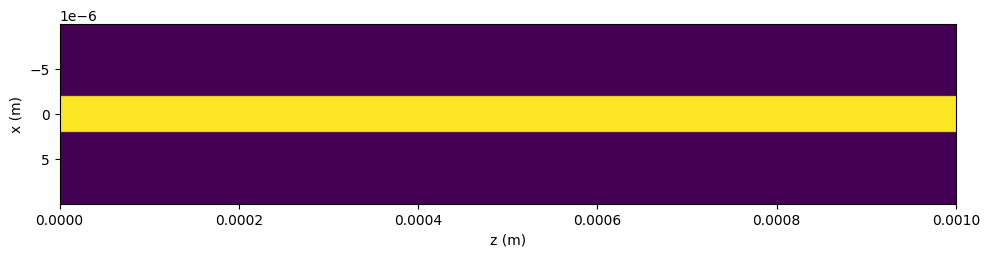

In [6]:
N = 100
Nz = 1000
refractive_index = torch.zeros(N, Nz)
wvl = 633e-9

x = torch.linspace(-10e-6, 10e-6, refractive_index.shape[0])
z = torch.linspace(0e-6, 1_000e-6, Nz)


r_core = 2e-6
n_core = 1.02
n_cladding = 1.0


refractive_index[:, :] = (n_core - n_cladding) * ((torch.abs(x) < r_core)).reshape(N, 1)
# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(refractive_index.cpu().numpy(), 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=10,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()